<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-and-Load-Data" data-toc-modified-id="Setup-and-Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup and Load Data</a></span></li><li><span><a href="#Defender-Distance" data-toc-modified-id="Defender-Distance-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Defender Distance</a></span></li><li><span><a href="#Shot-Distance" data-toc-modified-id="Shot-Distance-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Shot Distance</a></span></li><li><span><a href="#Shot-Distance-and-Defender-Distance" data-toc-modified-id="Shot-Distance-and-Defender-Distance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Shot Distance and Defender Distance</a></span><ul class="toc-item"><li><span><a href="#Hexbin-Plot" data-toc-modified-id="Hexbin-Plot-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Hexbin Plot</a></span></li></ul></li><li><span><a href="#Expected-Shot-Value" data-toc-modified-id="Expected-Shot-Value-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Expected Shot Value</a></span></li><li><span><a href="#An-Improved-Shooting-Metric?" data-toc-modified-id="An-Improved-Shooting-Metric?-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>An Improved Shooting Metric?</a></span><ul class="toc-item"><li><span><a href="#Player-ESV" data-toc-modified-id="Player-ESV-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Player ESV</a></span></li><li><span><a href="#Team-ESV-per-85-FGA" data-toc-modified-id="Team-ESV-per-85-FGA-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Team ESV per 85 FGA</a></span></li><li><span><a href="#Player-Points-Above-Average-per-FGA" data-toc-modified-id="Player-Points-Above-Average-per-FGA-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Player Points Above Average per FGA</a></span></li><li><span><a href="#Team-Points-Above-Average-per-85-FGA" data-toc-modified-id="Team-Points-Above-Average-per-85-FGA-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Team Points Above Average per 85 FGA</a></span></li></ul></li><li><span><a href="#Does-Defender-Distance-Relate-to-Shooter-Quality?" data-toc-modified-id="Does-Defender-Distance-Relate-to-Shooter-Quality?-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Does Defender Distance Relate to Shooter Quality?</a></span></li></ul></div>

# Expected Value Modeling for NBA Shot Locations

We should expect that two important drivers of the likelihood of making a shot are the shot distance and how near the closest defender is.  Using data obtained from NBA.com for the 2014-2015 season, this demo explores how you can build an expected value model for shooting.

## Setup and Load Data

In [1]:
%run ../../utils/notebook_setup.py

Adding datascience helper tools to path...
Setting up Matplotlib...
Matplotlib imported as mpl
Matplotlib.pyplot imported as plt


In [2]:
%matplotlib inline
import datascience as ds
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from datascience_utils import hexbin_plot, sorted_boxplot
from datascience_topic import build_expected_shot_values_from_hexbin

In [3]:
t = ds.Table.read_table('shot_logs_2014_15.csv.gz', sep=',')

In [4]:
t.show(5)

GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,playerName,SHOT_RESULT_BIN,PTS_MADE,CLOSE_DEF_DIST_ROUNDED,SHOT_DIST_ROUNDED,SHOT_DIST_BUCKET,DATE,PLAYER_TEAM,OPP_TEAM,HOME_TEAM,AWAY_TEAM
21401229,GSW vs. DEN,H,W,7,1,2,02:05,10.6,2,3.3,6.5,2,made,"Nurkic, Jusuf",203994,2.1,1,2,Andrew Bogut,1,2,2,6.5,3-10,2015-04-15,GSW,DEN,GSW,DEN
21401212,GSW vs. MEM,H,W,4,1,1,03:55,6.2,1,1.8,4,2,missed,"Koufos, Kosta",201585,1.9,0,0,Andrew Bogut,0,0,2,4,3-10,2015-04-13,GSW,MEM,GSW,MEM
21401212,GSW vs. MEM,H,W,4,2,1,03:54,5.2,0,0,2.8,2,made,"Koufos, Kosta",201585,2.2,1,2,Andrew Bogut,1,2,2,3,0-3,2015-04-13,GSW,MEM,GSW,MEM
21401212,GSW vs. MEM,H,W,4,3,3,10:02,16,0,1.5,8.4,2,made,"Udrih, Beno",2757,4.4,1,2,Andrew Bogut,1,2,4,8.5,3-10,2015-04-13,GSW,MEM,GSW,MEM
21401212,GSW vs. MEM,H,W,4,4,3,08:26,1.4,0,0,4.5,2,made,"Randolph, Zach",2216,4.4,1,2,Andrew Bogut,1,2,4,4.5,3-10,2015-04-13,GSW,MEM,GSW,MEM


## Defender Distance
There are lots of things you could do with this data but let's just jump right in with defender distance.

We use the 1ft buckets in `CLOSE_DEF_DIST_ROUNDED` to compute FG% as a function of defender distance.

After grouping, we plot the relation and... wait, why does defender distance not seem to matter!?

_Question_
+ What might explain this seeming lack of relationship?  Does shot type matter?  Anything else?

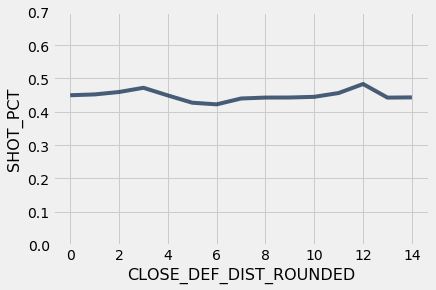

In [5]:
result = t.select('CLOSE_DEF_DIST_ROUNDED', 'SHOT_RESULT_BIN').\
    group('CLOSE_DEF_DIST_ROUNDED', collect=np.mean)

result = result.relabel('SHOT_RESULT_BIN mean', 'SHOT_PCT')
result.where('CLOSE_DEF_DIST_ROUNDED', ds.are.below_or_equal_to(14)).\
    plot(column_for_xticks='CLOSE_DEF_DIST_ROUNDED', select='SHOT_PCT')

plt.gca().set_ylim(0, .7);

Okay, now we separate by shot type.  Clearly defender distance is a big deal for 3pt shots.  But it still doesn't seem that important for 2pt shots.

_Question_
+ Should 2pt shooting % be immune defender distance?  Why or why not?  Is there something else missing?

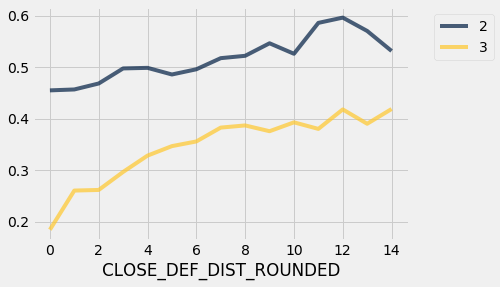

In [6]:
result = t.select('PTS_TYPE', 'CLOSE_DEF_DIST_ROUNDED', 'SHOT_RESULT_BIN').\
    group(['PTS_TYPE', 'CLOSE_DEF_DIST_ROUNDED'], collect=np.mean)

result = result.relabel('SHOT_RESULT_BIN mean', 'SHOT_PCT')

result = result.pivot('PTS_TYPE', 'CLOSE_DEF_DIST_ROUNDED', values='SHOT_PCT', collect=np.mean)
result.where('CLOSE_DEF_DIST_ROUNDED', ds.are.below_or_equal_to(14)).\
    plot(column_for_xticks='CLOSE_DEF_DIST_ROUNDED', select=['2', '3'])

## Shot Distance

We can quickly visualize the variability in shot distance with a pair of histogram plots.  The distance of the NBA 3pt line is not uniform but generally you see the overall pattern of shots.

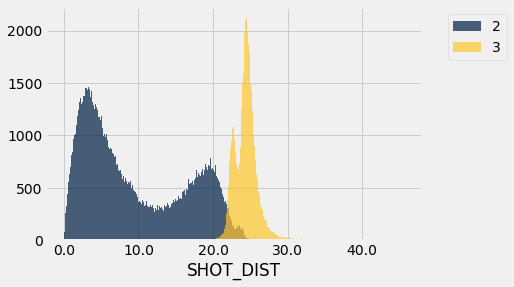

In [7]:
t.select('PTS_TYPE', 'SHOT_DIST').\
    pivot('PTS_TYPE', 'SHOT_DIST').\
    bar('SHOT_DIST', select=['2', '3'])

We can group by shot type and shot distance (rounded to nearest half foot) to get a feel for how shooting percentage varies with shot distance.  Obviously close in shots are layups/dunks that are almost always converted.

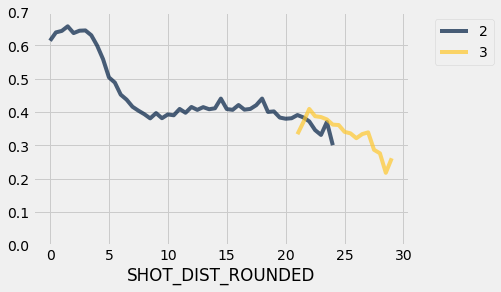

In [8]:
result = t.select('PTS_TYPE', 'SHOT_DIST_ROUNDED', 'SHOT_RESULT_BIN').\
    group(['PTS_TYPE', 'SHOT_DIST_ROUNDED'], collect=np.mean)

result = result.relabel('SHOT_RESULT_BIN mean', 'SHOT_PCT')

result = result.pivot('PTS_TYPE', 'SHOT_DIST_ROUNDED', values='SHOT_PCT', collect=np.mean)

result['2'][result['SHOT_DIST_ROUNDED'] > 24] = np.nan
result['3'][(result['SHOT_DIST_ROUNDED'] < 21) | (result['SHOT_DIST_ROUNDED'] > 29)] = np.nan

result.plot(column_for_xticks='SHOT_DIST_ROUNDED', select=['2', '3'])
plt.gca().set_ylim(0, .7);

## Shot Distance and Defender Distance

Okay, we saw defender distance mattered for 3s and shot distance matters.  Let's combine the two.  We use the shot distance buckets in `SHOT_DIST_BUCKET` as well as the rounded defender distance to show how shooting percentage varies both in shot distance and defender distance.

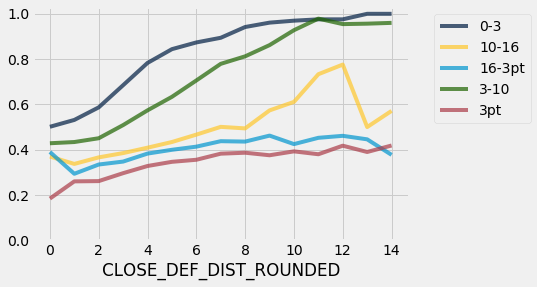

In [9]:
result = t.select('SHOT_DIST_BUCKET', 'CLOSE_DEF_DIST_ROUNDED', 'SHOT_RESULT_BIN').\
    group(['SHOT_DIST_BUCKET', 'CLOSE_DEF_DIST_ROUNDED'], collect=np.mean)
result = result.relabel('SHOT_RESULT_BIN mean', 'SHOT_PCT')

result = result.pivot(
    'SHOT_DIST_BUCKET', 'CLOSE_DEF_DIST_ROUNDED', values='SHOT_PCT', collect=np.mean)
result.where('CLOSE_DEF_DIST_ROUNDED', ds.are.below_or_equal_to(14)).\
    plot(column_for_xticks='CLOSE_DEF_DIST_ROUNDED')
plt.gca().set_ylim(0, 1.03);

### Hexbin Plot

We can view the relationship between the in more continuous space with a hexbin plot.  A hexbin plot segments the space and all shots that lie within a hexagon will be grouped together.  Then within that hexagon, we will compute the shooting percentage.  We can see how regardless of shot distance, the defender distance near 0 drives down shooting percentage at that distance from the basket.

_Question_
+ Why are there some spots that are extra dark or white that don't really fit with the general pattern?
+ What is going on with that spike on the left side?  What kind of shot has a high percentage, is near the basket, and has no defender nearby?

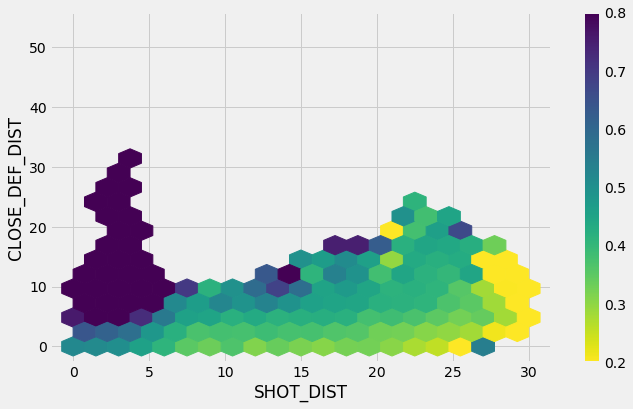

In [10]:
hexbin_plot(
    t.where('SHOT_DIST', ds.are.below_or_equal_to(30)),
    'SHOT_DIST',
    'CLOSE_DEF_DIST',
    C='SHOT_RESULT_BIN',
    collect=np.mean,
    gridsize=20,
    figsize=(10, 6),
    cmap=plt.cm.viridis_r,
    mincnt=5,
    vmin=0.2,
    vmax=0.8
);

## Expected Shot Value

We can do the same hexbin plot but compute expected points.  This makes more sense due to the 3pt line and represents a shooting efficiency due to the variable value of shots.

_Question_
+ What does this hexbin plot say about mid/long-distance 2s as well?  How bad is a closely guarded mid/long 2 point shot?

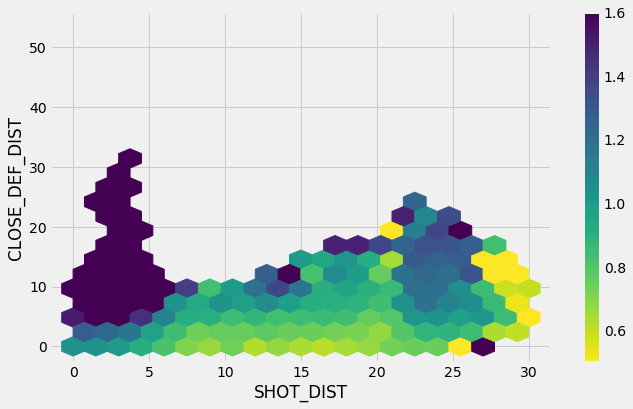

In [11]:
hexbin_esv_plot = hexbin_plot(
    t.where('SHOT_DIST', ds.are.below_or_equal_to(30)),
    'SHOT_DIST',
    'CLOSE_DEF_DIST',
    C='PTS_MADE',
    collect=np.mean,
    gridsize=20,
    cmap=plt.cm.viridis_r,
    figsize=(10, 6),
    mincnt=5,
    vmin=0.5,
    vmax=1.6
)

## An Improved Shooting Metric?

Recall the Effective Field Goal Pct was given by
$$
    \text{eFG\%} = \frac{\mathit{FG} + .5 \cdot \mathit{3FG}}{\mathit{FGA}} = \frac{\text{Total Points (excluding FT)}}{2 \cdot \mathit{FGA}}
$$

Ignoring the division by 2, our ESV computation is akin to the EFG computation: expected points scored per attempt.

Here's a metric we can build along what we've seen already in baseball: for each shot use the hexbin plot to compute the ESV.  

$$
    \text{eSV} = \frac{\text{Total Expected Points}}{\mathit{FGA}}
$$

We can also compute the points above average for each shot as
$$
    \text{Points Above Average} = \text{Points Made} - \text{eSV}
$$

This is actually akin to what was proposed in this [paper][1] at the Sloan conference.

[1]: http://www.sloansportsconference.com/wp-content/uploads/2014/02/2014-SSAC-Quantifying-Shot-Quality-in-the-NBA.pdf

In [12]:
# Use a helper function to get the bin (and therefore ESV) for each shot
esv = build_expected_shot_values_from_hexbin(
    t['SHOT_DIST'], t['CLOSE_DEF_DIST'], hexbin_esv_plot)
t['EXPECTED_SHOT_VALUE'] = esv

# remove Nan
not_nan = ~np.isnan(esv)
esv_t = t.where(not_nan)

In [13]:
esv_t.show(5)

GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,playerName,SHOT_RESULT_BIN,PTS_MADE,CLOSE_DEF_DIST_ROUNDED,SHOT_DIST_ROUNDED,SHOT_DIST_BUCKET,DATE,PLAYER_TEAM,OPP_TEAM,HOME_TEAM,AWAY_TEAM,EXPECTED_SHOT_VALUE
21401229,GSW vs. DEN,H,W,7,1,2,02:05,10.6,2,3.3,6.5,2,made,"Nurkic, Jusuf",203994,2.1,1,2,Andrew Bogut,1,2,2,6.5,3-10,2015-04-15,GSW,DEN,GSW,DEN,0.838157
21401212,GSW vs. MEM,H,W,4,1,1,03:55,6.2,1,1.8,4,2,missed,"Koufos, Kosta",201585,1.9,0,0,Andrew Bogut,0,0,2,4,3-10,2015-04-13,GSW,MEM,GSW,MEM,1.16842
21401212,GSW vs. MEM,H,W,4,2,1,03:54,5.2,0,0,2.8,2,made,"Koufos, Kosta",201585,2.2,1,2,Andrew Bogut,1,2,2,3,0-3,2015-04-13,GSW,MEM,GSW,MEM,1.22774
21401212,GSW vs. MEM,H,W,4,3,3,10:02,16,0,1.5,8.4,2,made,"Udrih, Beno",2757,4.4,1,2,Andrew Bogut,1,2,4,8.5,3-10,2015-04-13,GSW,MEM,GSW,MEM,0.901269
21401212,GSW vs. MEM,H,W,4,4,3,08:26,1.4,0,0,4.5,2,made,"Randolph, Zach",2216,4.4,1,2,Andrew Bogut,1,2,4,4.5,3-10,2015-04-13,GSW,MEM,GSW,MEM,1.44709


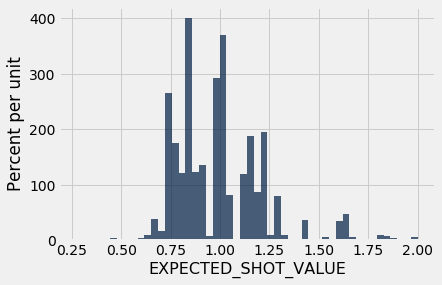

In [14]:
esv_t.hist('EXPECTED_SHOT_VALUE', bins=50)

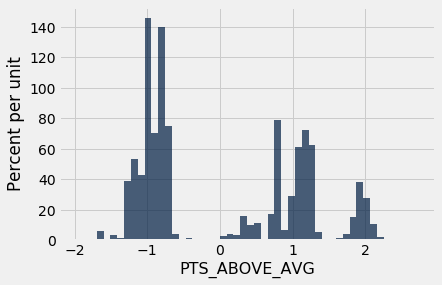

In [15]:
esv_t['PTS_ABOVE_AVG'] = esv_t['PTS_MADE'] - esv_t['EXPECTED_SHOT_VALUE']
esv_t.hist('PTS_ABOVE_AVG', bins=50)

### Player ESV
Which players are taking the highest value shots?  How about the lowest?

In [16]:
result = esv_t.select('playerName', 'EXPECTED_SHOT_VALUE').\
    group('playerName', collect=np.mean)
result_ct = esv_t.select('playerName').group('playerName')

player_esv = result.join('playerName', result_ct)

player_esv = player_esv.relabel('EXPECTED_SHOT_VALUE mean', 'ESVperFGA').\
    relabel('count', 'FGA')

In [17]:
player_esv.where('FGA', ds.are.above(100)).\
    sort('ESVperFGA', descending=True).\
    show(20)

playerName,ESVperFGA,FGA
Tyson Chandler,1.22568,434
Omer Asik,1.22375,411
DeAndre Jordan,1.22266,522
Joey Dorsey,1.17954,142
Andre Roberson,1.16277,197
Chris Andersen,1.16205,198
Rudy Gobert,1.15796,423
Tony Allen,1.15318,445
Reggie Evans,1.14828,136
Dewayne Dedmon,1.14296,157


In [18]:
player_esv.where('FGA', ds.are.above(100)).\
    sort('ESVperFGA', descending=False).\
    show(20)

playerName,ESVperFGA,FGA
A.J. Price,0.874659,136
Kobe Bryant,0.88085,706
Gary Neal,0.884172,502
Jason Smith,0.888279,586
Jamal Crawford,0.889882,821
Roy Hibbert,0.891569,707
Dirk Nowitzki,0.893061,1061
DeMar DeRozan,0.893843,984
Nick Young,0.895398,467
Jarrett Jack,0.895648,795


### Team ESV per 85 FGA 

Which teams take the best shots?  85 FGA is about 1 game.

In [19]:
result = esv_t.select('PLAYER_TEAM', 'EXPECTED_SHOT_VALUE').\
    group('PLAYER_TEAM', collect=np.mean)
result_ct = esv_t.select('PLAYER_TEAM').group('PLAYER_TEAM')

team_esv = result.join('PLAYER_TEAM', result_ct)

team_esv = team_esv.relabel('EXPECTED_SHOT_VALUE mean', 'ESVperFGA').\
    relabel('count', 'FGA')
    
team_esv['ESVper85FGA'] = 85 * team_esv['ESVperFGA']
team_esv.sort('ESVper85FGA', descending=True).show()

PLAYER_TEAM,ESVperFGA,FGA,ESVper85FGA
HOU,1.03721,6686,88.1631
ATL,1.0205,6623,86.7422
PHI,1.01785,6614,86.5171
UTA,1.01464,6436,86.2441
CLE,1.01393,6616,86.1843
PHX,1.01266,6940,86.0763
DET,1.0122,6969,86.0368
NOP,1.01173,6746,85.9968
DAL,1.01007,6990,85.8563
GSW,1.00922,7000,85.7833


### Player Points Above Average per FGA
We can compute PAA per FGA for each player.

In [20]:
result = esv_t.select('playerName', 'PTS_ABOVE_AVG').\
    group('playerName', collect=np.mean)
result_ct = esv_t.select('playerName').group('playerName')   

paa = result.join('playerName', result_ct)

paa.relabel('PTS_ABOVE_AVG mean', 'PAAperFGA').\
    relabel('count', 'FGA')

playerName,PAAperFGA,FGA
A.J. Price,-0.0143649,136
Aaron Brooks,0.0399828,800
Aaron Gordon,-0.100559,206
Adreian Payne,-0.106711,220
Al Horford,0.112368,956
Al Jefferson,0.0592335,1007
Al-Farouq Aminu,-0.187976,355
Alan Anderson,0.0998225,422
Alec Burks,-0.0833761,298
Alex Kirk,-0.504609,4


In [21]:
paa.where('FGA', ds.are.above(100)).\
    sort('PAAperFGA', descending=True).\
    show(20)

playerName,PAAperFGA,FGA
Kyle Korver,0.379402,596
Luke Babbitt,0.249144,192
Kevin Durant,0.227779,465
Hedo Turkoglu,0.226086,185
Stephen Curry,0.216537,1307
Brandan Wright,0.213496,361
JJ Redick,0.200852,933
Anthony Morrow,0.200743,613
DeAndre Jordan,0.200714,522
Hassan Whiteside,0.19178,380


In [22]:
paa.where('FGA', ds.are.above(100)).\
    sort('PAAperFGA', descending=True).\
    take[-20:].show()

playerName,PAAperFGA,FGA
Ramon Sessions,-0.164233,327
Luc Mbah a Moute,-0.165442,613
Cleanthony Early,-0.165908,212
Tyler Ennis,-0.166638,142
Jimmer Fredette,-0.168394,165
Lou Amundson,-0.179884,247
Al-Farouq Aminu,-0.187976,355
Omer Asik,-0.192123,411
Markel Brown,-0.194708,208
Archie Goodwin,-0.199593,198


### Team Points Above Average per 85 FGA 
We can compute PAA per 85 FGA for each team.

In [23]:
paa_team = esv_t.select('PLAYER_TEAM', 'PTS_ABOVE_AVG').\
    group('PLAYER_TEAM', collect=np.mean).\
    relabel('PTS_ABOVE_AVG mean', 'PAAperFGA')
paa_team['PAAper85FGA'] = 85 * paa_team['PAAperFGA']
paa_team.sort('PAAper85FGA', descending=True).show()

PLAYER_TEAM,PAAperFGA,PAAper85FGA
GSW,0.0767843,6.52667
LAC,0.0756277,6.42836
SAS,0.0390337,3.31786
ATL,0.0374833,3.18608
POR,0.0329869,2.80389
TOR,0.0311852,2.65074
CLE,0.0289933,2.46443
BKN,0.0241992,2.05693
DAL,0.0213988,1.8189
WAS,0.0177247,1.5066


## Does Defender Distance Relate to Shooter Quality?

Presumably better shooters will be guarded more closely, right?  To study this, let's restrict to 3pt shots.

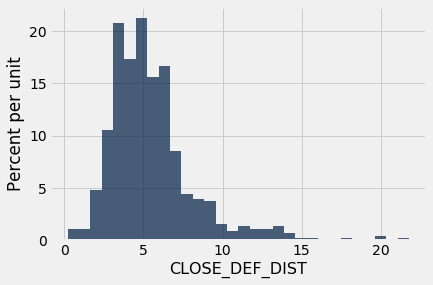

In [24]:
t.where('playerName', 'Stephen Curry').\
    where('PTS_TYPE', 3).\
    hist('CLOSE_DEF_DIST', bins=30)

We take all players with at least 50 shots, sort them by their 3FG% (from left to right), and construct boxplots showing defender distance.  If 3FG% indicates better shooters, and it should, then those players should be guarded tighter than poor shooters. We should see some kind of pattern in the plot that will reflect this hypothesis.

_Question_
+ What pattern emerges from this plot?  Can you think of a plausible explanation? 

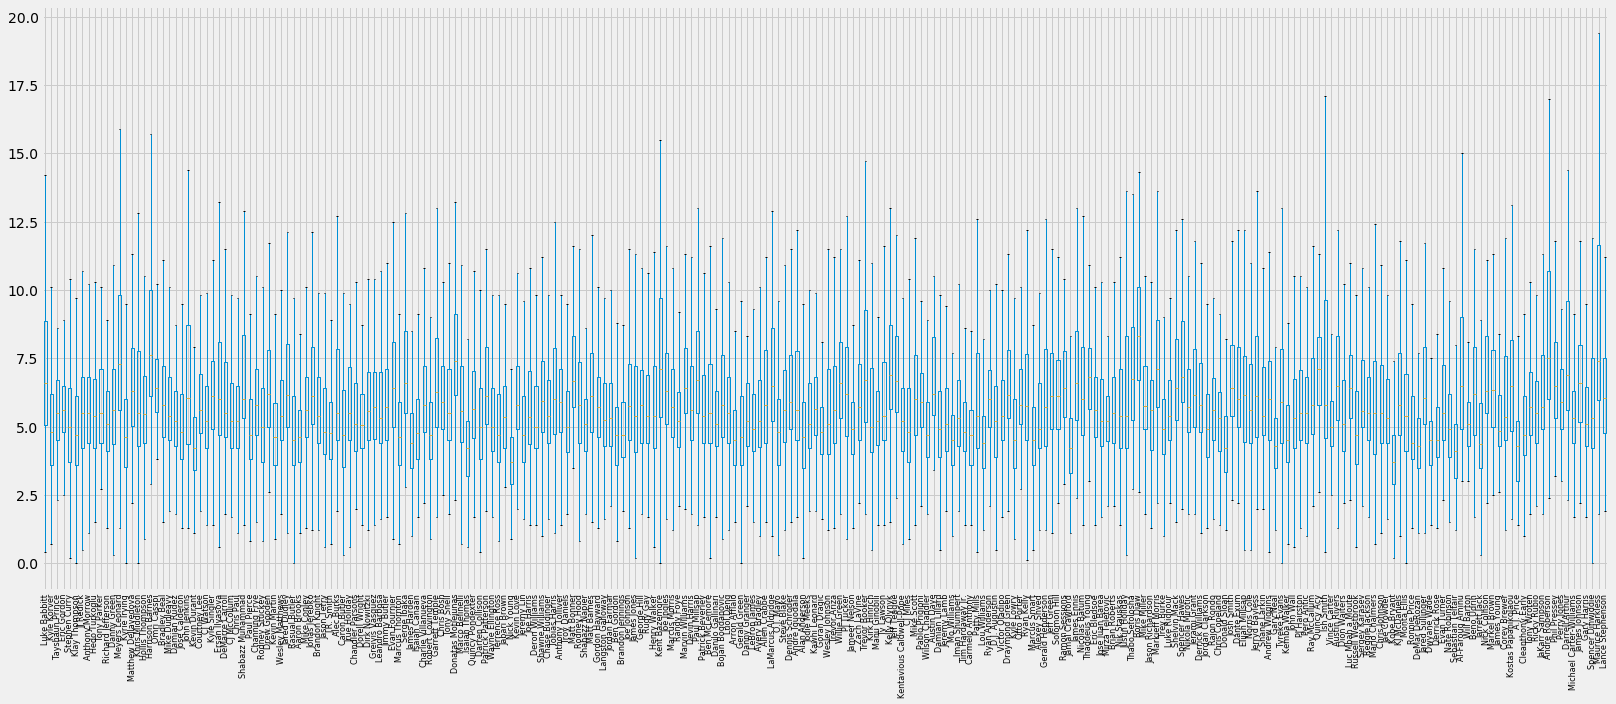

In [25]:
num_3pt_shots = 50
by = 'playerName'
column = "CLOSE_DEF_DIST"

three_pt_shots = t.where('PTS_TYPE', 3)

result = three_pt_shots.select(by, 'SHOT_RESULT_BIN').\
    group(by, collect=np.mean)
result2 = three_pt_shots.select(by).group(by)
result = result.join(by, result2)
result.relabel('SHOT_RESULT_BIN mean', '3FG%').\
    relabel('count', 'FGA')
    
by_3pt_pct = result.where('FGA', ds.are.above(num_3pt_shots)).\
    sort('3FG%', descending=True) 
    
sorted_boxplot(
    three_pt_shots.to_df(),
    by,
    column,
    by_3pt_pct[by],
    figsize=(25, 10),
    fontsize=8
)